In [1]:
%load_ext autoreload
%autoreload 2

# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle,time
from scipy.constants import c
from LumericalLibraries.mode_solutions import mode_sol
from LumericalLibraries.overlap_calc import Overlap_calc
from itertools import product

import L_eff

# Define functions

In [3]:
def calc_peak_power(avg,rep,width):
    ''' Caclulates peak power from average power rep rate and pulse width '''
    pulse_energy = avg/rep

    return 0.94*(1-0.27)*pulse_energy/width #lobe correction
def effective_length(pulse_width1,pulse_width2,beta1):

    ''' Caclulates the effective interaction length of 2 pulses with given pulse widths and group velocities '''

    # prefactor  = np.sqrt(2)/(0.441271*np.pi*2)
    prefactor  = (4*np.sqrt(np.log(2)))/(0.441271*np.pi*2)
    numerator = np.sqrt(pulse_width1**2 + pulse_width2**2)
    denomenator = abs(beta1[0] - beta1[1])

    return (prefactor * numerator)/denomenator

def phase_shift(L,ng_p,ng_s,overlap,power,wav):
    
    n2 = 2.4e-19 #nonlinear refractive index of silicon nitride
    n0 = 1.984675 #refractive index of silicon nitride
    
    prefactor = (4*np.pi*n2)/wav
    ns = ((ng_p * ng_s)/n0**2)

    return prefactor*ns* overlap * power * L

# Simulation parameters

Note that the general simulation parameters are also defined within the Overlap_calc class - definitely bad coding form so feel free to change that.

In [18]:
width = 1.95*1e-6
#L_array = [30,35,40,45,50,60,70,80] #length of waveguide in mm

L = 45 #length of waveguide in mm
f_rep = 50 #MHz

#Pulse 1 - sig.: TE0, 1555nm, 6.18ps
tau_p01 = 6.18 #pulse length in ps
P_avg01 = -27 #dBm
lamb_01 = 1536 #nm

#Pulse 2 - pump: TE1, 1560nm, 3.87ps
tau_p02 = 3.87 #pulse length in ps
P_avg02 = 10 #dBm
lamb_02 = 1560 #nm

In [19]:
'''silicon nitride'''

simulation_params_nitride = {
'width': 2e-6,
'height':330e-9,
'top_cladding_thickness': 0.75e-6,
'bottom_cladding_thickness':13.3e-6,
'Mode_resolution':100,
'material_wg': "SiN (Silicon Nitride) - MuensterSpecs",
'material_clad': "HSQ - Munster spec"
}

#start_wavelength = 1.550e-6
#stop_wavelength = 1.565e-6
if lamb_01<lamb_02:
    start_wavelength = lamb_01*1e-9#1.536e-6
    stop_wavelength = lamb_02*1e-9#1.560e-6
else:
    start_wavelength = lamb_02*1e-9#1.536e-6
    stop_wavelength = lamb_01*1e-9#1.560e-6
points = 10#5#20
step = (stop_wavelength-start_wavelength) / (points-1)


general_params = {
"wavelength" : (start_wavelength+stop_wavelength)/2, #1.5575e-6,
"start_wavelength":start_wavelength,
"stop_wavelength":stop_wavelength,
"N_points_Disp":points,
"d_wavelength" :step,
"Lc" : 1e-6,
"mesh_dx" : 0.1e-6,
"mesh_dy" : 0.1e-6,
"substrate_height": 2e-6,
"num_TE" : 4
} 


# Example sweeps just in MODE

Two example sweeps. First we will perform a sweep of the waveguide width but always at a fixed wavelength, and plot the effective indices of the transverse electric modes. Second we will perform a wavelength sweep for a fixed geometry and again plot the effective index of the transverse electric modes. The example plots have been performed with a large mesh so might not be too accurate.

In [6]:
simulation_params = dict()
simulation_params.update(simulation_params_nitride)
simulation_params.update(general_params)
MODE = mode_sol(simulation_params, hide = False, close = False, mode = 'TE') #open model_solutions.py and initialize lumerical

Initialising MODE instance...
Inputting simulation parameters...
Fitting material parameters...
Initialisation complete


In [20]:
n01 = 1.984675
n02 = 1.984675
'''width sweep'''
param_sweep = {
    'parameter':'width',
    'parameter_start': width,
    'parameter_end': width,
    'steps': 1
}
neff_array = MODE.parameter_sweep(param_sweep) # create array of n_eff for diferent width of waveguide (defined in param_sweep) and supported TE
neff_plot_arrays = [[] for _ in range(MODE.simulation_parameters['num_TE'])]
neff_array,vg_array,D_array,wavs = MODE.freq_sweep() # go through  wavelenghts for single wavegide geometry

Performing parameter sweep
Sweep complete
Performing frequency sweep
Sweep complete


Initialising MODE instance...
Inputting simulation parameters...
Fitting material parameters...
Initialisation complete
Getting mode info...


/home/martab/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:234: ComplexWarning: Casting complex values to real discards the imaginary part
  nx, tx, ny, ty, c, fp, ier = dfitpack.regrid_smth(


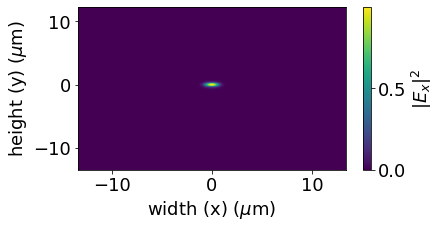

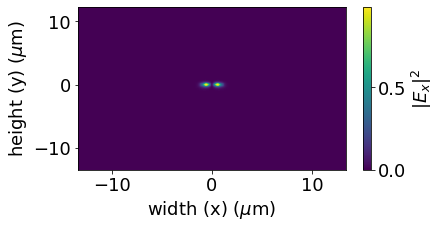

<Figure size 432x288 with 0 Axes>

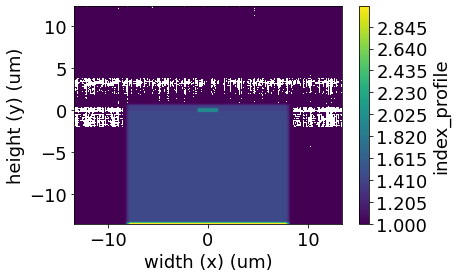

1536.0
1538.6301369863015
1541.269296740995
1543.9175257731958
1546.5748709122206
1549.241379310345
1551.917098445596
1554.602076124568
1557.296360485269
1560.0000000000002


In [21]:
v_g01 = vg_array[0][0]
lamb01 = wavs[0]*10**9
simulation_params['width']=width
    
#overlap
mode_indices = [0,1]
OL = Overlap_calc(simulation_params,mode_indices)
nonlinear_overlap,TE0_overlap,TE1_overlap,lin_ols = OL.NL_overlap(freq_sweep = 1)
vg_array = OL.vgs
lumerical_res=[nonlinear_overlap,TE0_overlap,TE1_overlap,lin_ols,vg_array]
    
Aeff01 = (1/TE0_overlap)* 1e12
Aeff02 = (1/TE1_overlap)* 1e12

L_res = []
for index2 in range(len(vg_array[0])):
    v_g02 = vg_array[1][index2]
    lamb02 = wavs[index2]*10**9
    print (lamb02)
    l_eff = L_eff.L_eff(L,f_rep,Aeff01,tau_p01,v_g01,lamb01,Aeff02,tau_p02,v_g02,lamb02,P_avg01,P_avg02,n01,n02)
    L_res.append(l_eff)

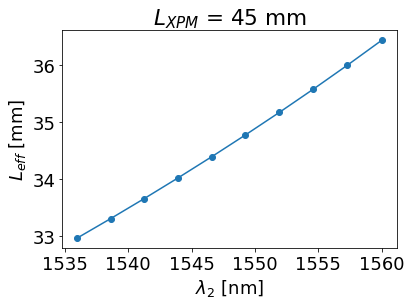

In [22]:
plt.plot(wavs*1e9,np.array(L_res)*1000,'o-')
plt.xlabel('$\lambda_2$ [nm]')
plt.ylabel('$L_{eff}$ [mm]')
plt.title('$L_{XPM}$ = ' + str(L) + ' mm')
plt.savefig('L_eff_on_delta_lamb_50MHz.pdf')
plt.show()

# Phase shift 

Example phase shift calculation for a single waveguide geometry. Sweep average power.

In [23]:
'''laser parameters'''

rep_rate = f_rep*1e6 #50e6
c = 3e8
lambda_signal = lamb01*1e-9 #1555e-9
#lambda_pump = lamb02*1e-9 #1560e-9

signal_pulse_width = tau_p01*1e-12 #6.18e-12 #5e-12
pump_pulse_width = tau_p02*1e-12 #3.87e-12 #4e-12

average_power_array = np.linspace(0,15,10)*1e-3

'''Switch geometry'''

#width = 2e-6
#length = L

'Switch geometry'

In [24]:
vg_array

array([[1.51506960e+08, 1.51542299e+08, 1.51577795e+08, 1.51613447e+08,
        1.51649258e+08, 1.51685229e+08, 1.51721360e+08, 1.51757654e+08,
        1.51794110e+08, 1.51830731e+08],
       [1.47772515e+08, 1.47843938e+08, 1.47917419e+08, 1.47993112e+08,
        1.48071192e+08, 1.48151853e+08, 1.48235313e+08, 1.48321820e+08,
        1.48411650e+08, 1.48505117e+08]])

In [25]:
v_g02-vg_array[1][-1]

0.0

In [26]:
index2

9

In [27]:
P_W = lambda P_dBm: 1/1000 *10**(P_dBm/10) # convert dBm to W
P_dBm = lambda P_W: 10* np.log10(1000*P_W) # convert W to dBm

### Without losses

In [28]:
loss_per_cm = 0. #loss per cm in dBm

def Get_phase(lumer,acc_L,average_power_array,L):
    [nonlinear_overlap,TE0_overlap,TE1_overlap,lin_ols,vg_array] = lumer
    beta1_pump = 1/vg_array[1][index2]
    beta1_signal = 1/vg_array[0][index1]

    ngp = c/vg_array[1][index2]
    ngs = c/vg_array[0][index1]
    
    phase_shifts = []
    for avg_power in average_power_array:
        if avg_power != 0:
            avg_power = P_W(P_dBm(avg_power) - loss_per_cm*L)
        peak_power = calc_peak_power(avg_power,rep_rate,pump_pulse_width)
        PS = phase_shift(acc_L,ngp,ngs,nonlinear_overlap,peak_power,lambda_signal)/np.pi
        phase_shifts.append(PS)
    return (phase_shifts)

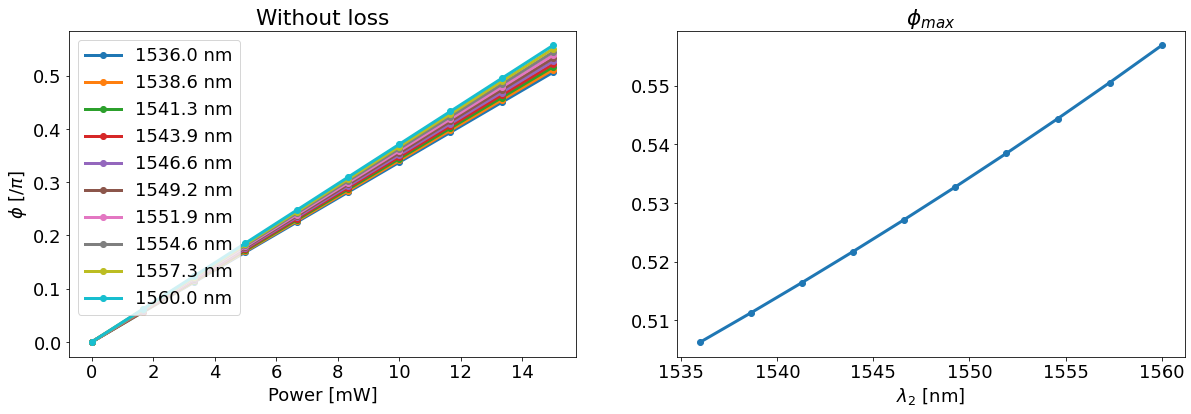

In [29]:
#fig,ax = plt.subplots(figsize = (10,6))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,6))
phaseList_2 = []
ax1.set_xlabel(r'Power [mW]')
ax2.set_xlabel('$\lambda_2$ [nm]')
ax1.set_ylabel(r'$\phi$ [/$\pi$]')
#for j,L in enumerate(L_array):
for j in range(len(vg_array[0])):
    index1 = 0
    index2 = j
    phase_shifts = Get_phase(lumerical_res,L_res[j],average_power_array,L/10)
    phaseList_2.append(max(phase_shifts))
    ax1.plot(average_power_array*1e3,phase_shifts,'-o',lw = 3, label = str(round(wavs[j]*1e9,1)) + ' nm')
ax2.plot(wavs*1e9,phaseList_2,'-o',lw = 3,label='Without loss')
#ax2.plot(L_array,phaseList,'-o',lw = 3,label='With loss')
ax1.legend()
#ax2.legend()
ax1.set_title('Without loss')
ax2.set_title('$\phi_{max}$')
plt.savefig('Phase_on_delta_lamb_50MHz.pdf')
plt.show()

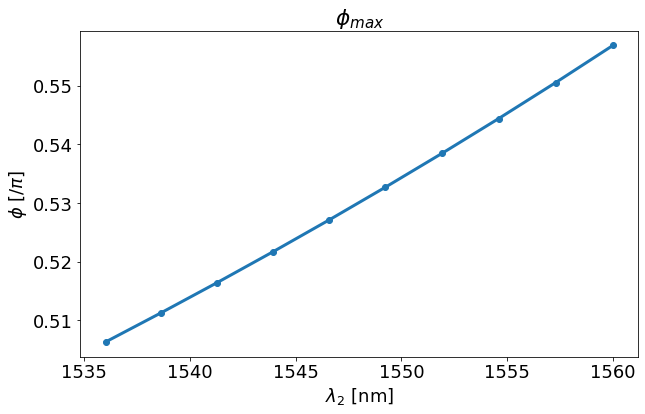

In [30]:
fig, ax2 = plt.subplots(1, 1,figsize = (10,6))
ax2.set_xlabel('$\lambda_2$ [nm]')
ax2.set_ylabel(r'$\phi$ [/$\pi$]')
ax2.plot(wavs*1e9,phaseList_2,'-o',lw = 3,label='Without loss')
ax2.set_title('$\phi_{max}$')
plt.savefig('Max_phase_on_delta_lamb_50MHz.pdf')
plt.show()